In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=376caf0bdf22f80f92787679004712bde1bdb56b55f0ea6874987ae005e8e4eb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ce6a27e2ee09ac94c5d20d60a0d7413ad8272c81491cbd78355f89ef628ff5ea
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

## **Download Dataset**

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 48.19 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## **Some Common Imports**

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## **Setup Configurations**

In [5]:
csv_file = "/kaggle/working/Human-Segmentation-Dataset-master/train.csv"
data_dir = "kaggle/working//kaggle/working/Human-Segmentation-Dataset-master"

device = "cuda"

epochs = 40
lerning_rate = 0.0001
image_size = 320
batch_size = 16

encoder = "timm-efficientnet-b0"
weights = "imagenet"

## **plot some of the image**

In [6]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

#define path
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

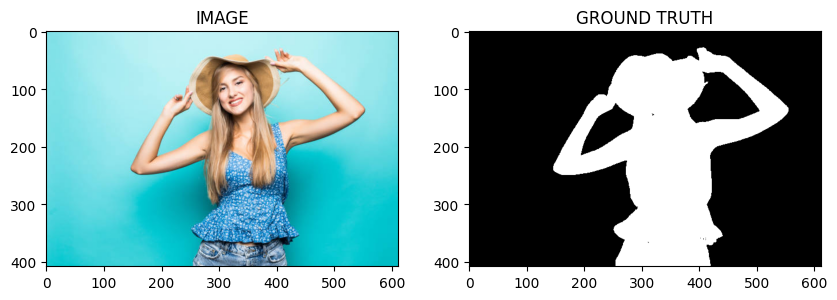

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

## **split the dataset into train and validation set**

In [9]:
train_df , valid_df = train_test_split(df, test_size=0.2, random_state=42)

## **Augmentation**

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
      ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
      ], is_check_shapes=False)

## **Create Custom Dataset**

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df , augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis= -1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      #(h,w,c) -> (c,h,w)
      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [14]:
train_set = SegmentationDataset(train_df , get_train_augs())
Valid_set = SegmentationDataset(valid_df , get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(Valid_set)}")

Size of Trainset : 232
Size of Validset : 58


## **Load dataset into batches**

In [16]:
from torch.utils.data import DataLoader

In [17]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(Valid_set, batch_size)

In [18]:
print(f"total number of batches in train loader : {len(train_loader)}")
print(f"total number of batches in valid loader : {len(valid_loader)}")

total number of batches in train loader : 15
total number of batches in valid loader : 4


In [19]:
for image, mask in train_loader:
  break

print(f"one batche image shape: {image.shape}")
print(f"one batche mask shape: {mask.shape}")


one batche image shape: torch.Size([16, 3, 320, 320])
one batche mask shape: torch.Size([16, 1, 320, 320])


## **Create Segmentation Model**

In [20]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [21]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks= None):
   logits = self.arc(images)

   if masks != None :
     loss1 = DiceLoss(mode = "binary")(logits , masks)
     loss2 = nn.BCEWithLogitsLoss()(logits , masks)
     return logits , loss1+loss2

   return logits

In [22]:
model = SegmentationModel()
model.to(device);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 96.1MB/s]


## **Create Train and Validation Function**

In [23]:
def train_fn(dataloader, model, optimizer):
  model.train()

  total_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)



In [24]:
def eval_fn(dataloader, model):
  model.eval()

  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(device)
      masks = masks.to(device)

      optimizer.zero_grad()
      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(dataloader)



## **Train Model**

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = lerning_rate)

In [26]:
best_valid_loss = np.Inf

for epoch in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved_Model")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Saved_Model
Epoch : 1 Train_loss : 1.3289700826009114 Valid_loss : 1.148631364107132


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Saved_Model
Epoch : 2 Train_loss : 1.091862960656484 Valid_loss : 0.8118105232715607


100%|██████████| 4/4 [00:00<00:00,  7.36it/s]


Saved_Model
Epoch : 3 Train_loss : 0.8602174083391826 Valid_loss : 0.6940171867609024


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


Saved_Model
Epoch : 4 Train_loss : 0.6844978213310242 Valid_loss : 0.6064093112945557


100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


Saved_Model
Epoch : 5 Train_loss : 0.5734378298123678 Valid_loss : 0.5251547321677208


100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


Saved_Model
Epoch : 6 Train_loss : 0.5102104922135671 Valid_loss : 0.486388735473156


100%|██████████| 4/4 [00:00<00:00,  6.48it/s]


Saved_Model
Epoch : 7 Train_loss : 0.465440434217453 Valid_loss : 0.4369456321001053


100%|██████████| 4/4 [00:00<00:00,  7.16it/s]


Saved_Model
Epoch : 8 Train_loss : 0.435706506172816 Valid_loss : 0.41953184455633163


100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


Saved_Model
Epoch : 9 Train_loss : 0.40774771173795066 Valid_loss : 0.39042671024799347


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


Saved_Model
Epoch : 10 Train_loss : 0.3654234707355499 Valid_loss : 0.3727113753557205


100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Saved_Model
Epoch : 11 Train_loss : 0.35426182150840757 Valid_loss : 0.3519948273897171


100%|██████████| 4/4 [00:00<00:00,  7.28it/s]


Saved_Model
Epoch : 12 Train_loss : 0.34243268171946206 Valid_loss : 0.33797477185726166


100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Saved_Model
Epoch : 13 Train_loss : 0.3103156348069509 Valid_loss : 0.3250730559229851


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Saved_Model
Epoch : 14 Train_loss : 0.28535107175509133 Valid_loss : 0.3078899309039116


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Saved_Model
Epoch : 15 Train_loss : 0.27747348248958587 Valid_loss : 0.2953754663467407


100%|██████████| 4/4 [00:00<00:00,  7.29it/s]


Saved_Model
Epoch : 16 Train_loss : 0.2641437530517578 Valid_loss : 0.29143722355365753


100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


Saved_Model
Epoch : 17 Train_loss : 0.2592261046171188 Valid_loss : 0.277506560087204


100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


Saved_Model
Epoch : 18 Train_loss : 0.2474538336197535 Valid_loss : 0.2639930546283722


100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Saved_Model
Epoch : 19 Train_loss : 0.24404332141081492 Valid_loss : 0.2508252151310444


100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


Saved_Model
Epoch : 20 Train_loss : 0.24003154436747234 Valid_loss : 0.2496686950325966


100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Saved_Model
Epoch : 21 Train_loss : 0.22002535164356232 Valid_loss : 0.2352619282901287


100%|██████████| 4/4 [00:00<00:00,  7.31it/s]


Saved_Model
Epoch : 22 Train_loss : 0.2123288929462433 Valid_loss : 0.23221967369318008


100%|██████████| 4/4 [00:00<00:00,  7.29it/s]


Saved_Model
Epoch : 23 Train_loss : 0.19205870628356933 Valid_loss : 0.22455905005335808


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


Saved_Model
Epoch : 24 Train_loss : 0.1822062313556671 Valid_loss : 0.21627134829759598


100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


Saved_Model
Epoch : 25 Train_loss : 0.17932325502236685 Valid_loss : 0.211539126932621


100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Saved_Model
Epoch : 26 Train_loss : 0.17408530712127684 Valid_loss : 0.20894094184041023


100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Saved_Model
Epoch : 27 Train_loss : 0.1640420506397883 Valid_loss : 0.2044004313647747


100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


Saved_Model
Epoch : 28 Train_loss : 0.15840916335582733 Valid_loss : 0.2003990150988102


100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Saved_Model
Epoch : 29 Train_loss : 0.16040942867596944 Valid_loss : 0.19954407960176468


100%|██████████| 4/4 [00:00<00:00,  7.44it/s]


Saved_Model
Epoch : 30 Train_loss : 0.1602615108092626 Valid_loss : 0.19040245935320854


100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


Epoch : 31 Train_loss : 0.15432296941677728 Valid_loss : 0.19683975353837013


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Epoch : 32 Train_loss : 0.13537779748439788 Valid_loss : 0.1908954344689846


100%|██████████| 4/4 [00:00<00:00,  7.36it/s]


Saved_Model
Epoch : 33 Train_loss : 0.14648583779732385 Valid_loss : 0.1882649064064026


100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


Saved_Model
Epoch : 34 Train_loss : 0.1366117204229037 Valid_loss : 0.18633977696299553


100%|██████████| 4/4 [00:00<00:00,  7.35it/s]


Saved_Model
Epoch : 35 Train_loss : 0.13231103171904882 Valid_loss : 0.17940838262438774


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Saved_Model
Epoch : 36 Train_loss : 0.13206199953953426 Valid_loss : 0.1719394363462925


100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Epoch : 37 Train_loss : 0.13121601243813832 Valid_loss : 0.17732570320367813


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Epoch : 38 Train_loss : 0.13145100424687067 Valid_loss : 0.17653414607048035


100%|██████████| 4/4 [00:00<00:00,  7.46it/s]


Saved_Model
Epoch : 39 Train_loss : 0.12306625147660573 Valid_loss : 0.1661466248333454


100%|██████████| 4/4 [00:00<00:00,  7.56it/s]


Saved_Model
Epoch : 40 Train_loss : 0.11786769181489945 Valid_loss : 0.16202010959386826


## **Inference**

In [27]:
idx = 20

model.load_state_dict(torch.load("best_model.pt"))

image, mask = Valid_set[idx]

logits_mask = model(image.to(device).unsqueeze(0))  #(C,H,W) -> (1,C,H,W)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

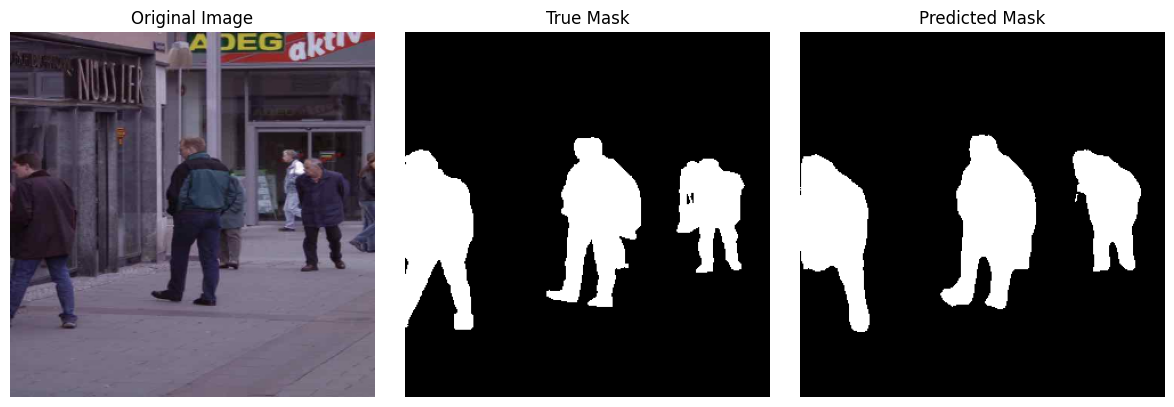

In [28]:
import matplotlib.pyplot as plt
import torch

def show_image(image, mask, pred_mask):
    # Check if inputs are PyTorch tensors and convert to NumPy arrays
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy().squeeze()  # Remove any singleton dimensions
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy().squeeze()  # Remove any singleton dimensions

    # Plot the images
    plt.figure(figsize=(12, 4))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Display the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

show_image(image, mask, pred_mask.detach().cpu().squeeze(0))